# Implementing Variational Inference on Neural Network

This notebeook is an implementation of variational inference for neural networks. Refering to Graves NeurIPS 2011, <a href="https://proceedings.neurips.cc/paper_files/paper/2011/file/7eb3c8be3d411e8ebfab08eba5f49632-Paper.pdf"> _Practical Variational Inference for Neural Networks_ </a>

## Outlook and some notation
- The code follows the Graves paper in building a neural network as a parametric model that assigns conditional probability $P(\mathcal{D}| \mathbf{w})$ for some dataset $\mathcal{D}$ given a set of $\mathbf{w} = \{w_i\}_{i=1}^W$ weights or parameters. This is a supervised learning problem with $(\mathbf{x}, \mathbf{y}) \in \mathcal{D}$ as input-target pairs assumed to be drawn _independently_ from the joint distribution $p(\mathbf{x}, \mathbf{y})$. In broad strokes, the loss is defined as:
$$L^N(\mathbf{w}, \mathcal{D}) = -\ln P(\mathcal{D} | \mathbf{w}) = - \sum_{(\mathbf{x}, \mathbf{y})} \ln P(\mathbf{y} | \mathbf{x}, \mathbf{w})$$

## Minimum Description Length (MDL)
Consider that the weights have some prior probability $P(\mathbf{w} | \mathbf{\alpha})$ where $\mathbf{\alpha}$ are some parameters. Whereas $Q(\mathbf{w} | \mathbf{\beta})$ is a tractable approximation. The MDL loss of the network can be described as:
$$L(\mathbf{\alpha}, \mathbf{\beta}, \mathcal{D}) = L^E(\mathbf{\beta, \mathcal{D}}) + L^C(\mathbf{\alpha, \beta})$$

Where $L^E$ is the error loss 

$$L^E = \langle L^N(\mathbf{w}, \mathcal{D}) \rangle _{w \sim Q}$$

And $L^C$ is the complexity loss which is the cost of describing the weights to the receiver

$$L^C(\mathbf{\alpha}, \mathbf{\beta}) = D_{KL} (Q(\beta) || P(\alpha))$$

## Gaussian Posterior
For the purposes of this notebeook, we assume the distribution for $Q(\mathbf{\beta})$ be a diagonal Gaussian. So each weight requires a mean and a variance parameter to describe it $\mathbf{\beta} = \{\mathbf{\mu}, \mathbf{\sigma^2}\}$. 

The approach described in the paper is to consider the varianves of $Q(\mathbf{\beta})$ _fixed_ and optimize only the means. In this case, the complicated MCMC sampling used to find the derivatives, we can use zero-mean, fixed variance _Gaussian noise_ to the network weights during training. 

- If $P(\alpha)$ is uniform and a single weight sample is taken for each element of $\mathcal{D}$, minimizing the loss $L(\alpha, \beta, \mathcal{D})$ is identical to minimizing $L^N(\mathbf{w}, \mathcal{D})$ with the _weight noise_ added. 

- If a Gaussian prior with $\alpha = \{\mu, \sigma^2\}$ is used instead, then the complexity loss function reduces to

$$L^C(\mathbf{\alpha}, \mathbf{\beta}) = \sum_{i=1}^W \ln \frac{\sigma}{\sigma_i} + \frac{1}{2\sigma^2} \Big((\mu_i - \mu)^2 + \sigma_i^2 - \sigma^2 \Big)$$

$$\frac{\partial L^C (\alpha, \beta)}{\partial \mu_i} = \frac{\mu_i - \mu}{\sigma^2}$$
and
$$\frac{\partial L^C (\alpha, \beta)}{\partial \sigma_i^2} = \frac{1}{2} \Big(\frac{1}{\sigma^2} - \frac{1}{\sigma_i^2}\Big)$$

In [2]:
import jax
import jax.numpy as jnp
import flax
from flax import nnx
from flax.nnx.nn import initializers
import optax
from functools import partial

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns



2025-04-10 19:20:09.869321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744338009.883021 1359139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744338009.887001 1359139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define a model

In [10]:
class BayesLinear(nnx.Module):
    """
    Base class for impmenenting Variational Inference on a neural network
    """

    def __init__(self, in_size: int, out_size: int, rngs: nnx.Rngs, prior_mean: float = 0.0, prior_var: float = 1e-6):

        self.in_size = in_size
        self.out_size = out_size
        self.rngs = rngs
        self.prior_mean = prior_mean
        self.prior_var = prior_var

        # mean and variances
        # glorot_initializer = initializers.glorot_normal()
        # self.w_mu = nnx.Param(glorot_initializer(self.rngs.params(), (self.out_size, self.in_size)))
        # self.w_logvar = nnx.Param(glorot_initializer(self.rngs.params(), (self.out_size, self.in_size)))

        # self.b_mu = nnx.Param(glorot_initializer(self.rngs.params(), (1, self.out_size)))
        # self.b_logvar = nnx.Param(glorot_initializer(self.rngs.params(), (1, self.out_size)))

        self.w_mu = nnx.Param(jnp.full((self.out_size, self.in_size), self.prior_mean))
        self.w_logvar = nnx.Param(jnp.full((self.out_size, self.in_size), jnp.log(self.prior_var)))
        self.b_mu = nnx.Param(jnp.full((1, self.out_size), self.prior_mean))
        self.b_logvar = nnx.Param(jnp.full((1, self.out_size), jnp.log(self.prior_var)))

    def __call__(self, x: jax.Array):
        """
        Forward pass
        """

        w_var = jnp.exp(0.5* self.w_logvar.value)
        b_var = jnp.exp(0.5* self.b_logvar.value)

        # sample weights and biases using reparametrization trick
        W = self.w_mu.value + jax.random.normal(self.rngs.sample(), self.w_mu.shape) * w_var
        b = self.b_mu.value + jax.random.normal(self.rngs.sample(), self.b_mu.shape) * b_var

        # print(W.shape, b.shape)
        # print(W, b)

        y = jnp.einsum('ij, bj -> bi', W, x) + b # b in the einsum is for batch size
        # print(y)

        return y

class BayesMLP(nnx.Module):
    """
    Simple MLP model for variational inference.
    """

    def __init__(self, layer_sizes: list, rngs: nnx.Rngs):
        """
        Initialize the network
        """

        self.layer_sizes = layer_sizes
        self.rngs = rngs

        # generate layers
        self.mlp_layers = []

        for li, lo in zip(self.layer_sizes[:-1], self.layer_sizes[1:]):
            layer = BayesLinear(in_size=li, out_size=lo, rngs=rngs)
            self.mlp_layers.append(layer)
        
    def __call__(self, x: jax.Array):
        """
        Forward pass
        """

        for layer in self.mlp_layers:
            x = layer(x)

            if layer is not self.mlp_layers[-1]:
                x = jax.nn.relu(x)

        # print(x)
        
        return x


Gradients = State({
  'mlp_layers': {
    0: {
      'b_logvar': VariableState( # 10 (40 B)
        type=Param,
        value=Array([[-0.0000000e+00,  2.3931481e-08, -9.8819889e-08, -4.7522906e-08,
                -4.8292192e-09,  1.1645089e-07, -0.0000000e+00,  1.9579487e-09,
                 1.3403687e-07,  2.7574236e-08]], dtype=float32, weak_type=True)
      ),
      'b_mu': VariableState( # 10 (40 B)
        type=Param,
        value=Array([[ 0.0000000e+00, -4.8364670e-04,  2.8016733e-04, -1.7350243e-04,
                -3.2810683e-05,  2.3135144e-04,  0.0000000e+00,  8.7747627e-05,
                -4.6683004e-04,  7.2696530e-05]], dtype=float32, weak_type=True)
      ),
      'w_logvar': VariableState( # 20 (80 B)
        type=Param,
        value=Array([[ 0.0000000e+00, -0.0000000e+00],
               [-2.7538009e-08, -3.0481510e-07],
               [ 4.0596149e-08,  7.4373233e-08],
               [-3.4974001e-08, -8.3687638e-08],
               [ 4.3822773e-08, -7.6415185e-09],

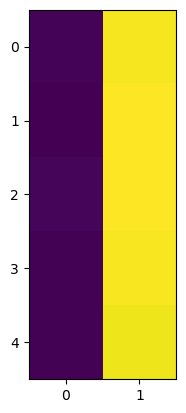

In [11]:
# testing the forward pass of the model
rngs = nnx.Rngs(params=0, sample=1)
x_test = jax.random.normal(rngs.params(), (5, 2))
# print(f"test input: {x_test}")
layers = [2, 10, 2]
test_model = BayesMLP(layer_sizes=layers, rngs=rngs)
y_out = test_model(x_test)
nnx.display(test_model)
# confirm if gradients can flow
y_labels = jnp.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]])
loss_fn = lambda model, x, y_labels: jnp.mean((model(x) - y_labels)**2)
grad_fn = nnx.grad(loss_fn)
grads = grad_fn(test_model, x_test, y_labels)
print(f"Gradients = {grads}")
plt.imshow(y_out)

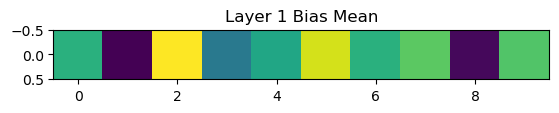

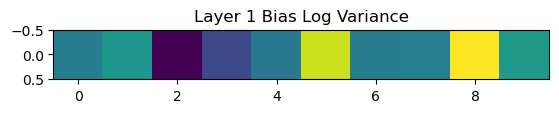

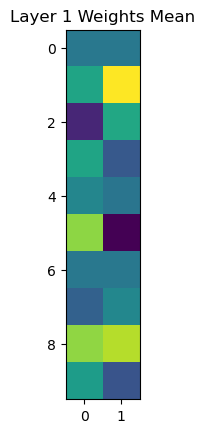

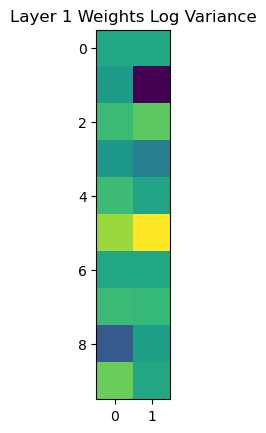

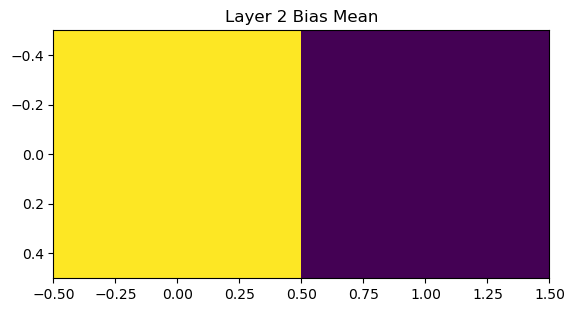

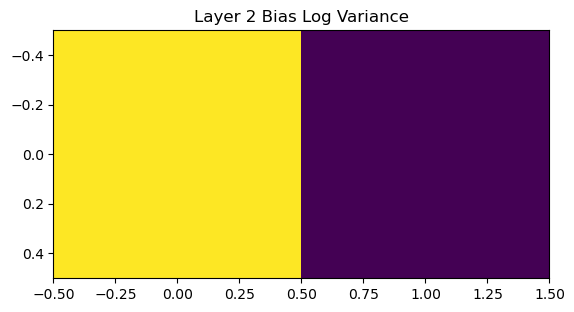

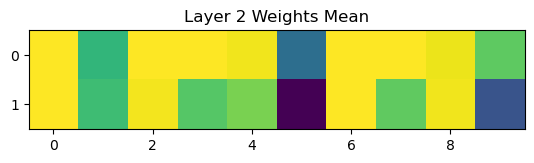

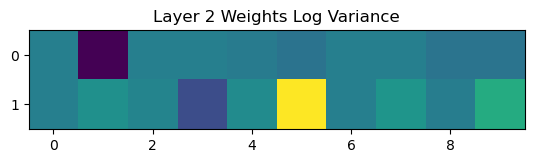

In [12]:
# visualing the dummy gradients
for k, v in grads.mlp_layers.items():
    plt.figure()
    b_mu = v.b_mu.value
    b_logvar = v.b_logvar.value
    w_mu = v.w_mu.value
    w_logvar = v.w_logvar.value
    plt.imshow(b_mu)
    plt.title(f"Layer {k+1} Bias Mean")
    plt.figure()
    plt.imshow(b_logvar)
    plt.title(f"Layer {k+1} Bias Log Variance")
    plt.figure()
    plt.imshow(w_mu)
    plt.title(f"Layer {k+1} Weights Mean")
    plt.figure()
    plt.imshow(w_logvar)
    plt.title(f"Layer {k+1} Weights Log Variance")

    # print(f"b_mu: {b_mu}")
    # print(f"b_logvar: {b_logvar}")
    # print(f"w_mu: {w_mu}")
    # print(f"w_logvar: {w_logvar}")
    # print("-----------------------")


## Defining the loss functions from the paper

In [ ]:
# defin the error loss as softmax cross-entropy loss
def error_loss(model: nnx.Module, x: jax.Array, y_labels: jax.Array):
    """
    Error loss function.
    - Average of the legative log-likelihood of the output.
    - Since we case this as a classification problem, the log-likelihood is the softmax cross-entropy loss.
    """

    pred = model(x)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=pred, labels=y_labels).mean()
    return loss


## Loading the data